## Accessing MODIS imagery data with the Planetary Computer STAC API

The planetary computer hosts three imagery-related MODIS 6.1 products:

- Surface Reflectance 8-Day 500m (09A1) 
- Surface Reflectance 8-Day 250m (09Q1)
- Nadir BRDF-Adjusted Reflectance (NBAR) Daily 500m (43A4)

For more information about the products themselves, check out the User Guide at the [bottom of this document](#user-guides).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
import odc.stac
import planetary_computer
import shapely.geometry
from pystac_client import Client
import rich.table

### Query for available data

MODIS is a global dataset with a variety of products available within each larger category (vegetation, snow, fire, temperature, and reflectance). The [MODIS group](https://planetarycomputer.microsoft.com/dataset/group/modis) contains a complete listing of available collections. Each collection's format follows`modis-{product}-061`, where `product` is the MODIS product id. The `-061` suffix indicates that all of the MODIS collections are part of the [MODIS 6.1 update](https://atmosphere-imager.gsfc.nasa.gov/documentation/collection-61).

Let's access the Surface Reflectance 8-Day (09A1) data near Mount Whitney in California.

In [2]:
# Open the Planetary Computer STAC API

URL = "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
catalog = Client.open(URL)
catalog

<Client id=microsoft-pc>

In [3]:
# Mount Whitney in CA
location = shapely.geometry.Point(-118.2923, 36.5785)
bbox = location.buffer(2).bounds
datetimes = [
    "2021-12-03",
    "2021-12-11",
    "2021-12-19",
]

buffer = 2
items = dict()

# Fetch the collection of interest and print availabe items

for datetime in datetimes:
    print(f"Fetching {datetime}")
    search = catalog.search(
        collections=["modis-09A1-061"],
        intersects=location,
        datetime=datetime,
    )
    item = search.get_all_items()[0]
    items[datetime] = planetary_computer.sign(item)

print(items)

Fetching 2021-12-03
Fetching 2021-12-11
Fetching 2021-12-19
{'2021-12-03': <Item id=MYD09A1.A2021337.h08v05.061.2021346053944>, '2021-12-11': <Item id=MYD09A1.A2021345.h08v05.061.2021355051559>, '2021-12-19': <Item id=MYD09A1.A2021353.h08v05.061.2022003220209>}


### Available Assets

Each item has several available assets, including the original HDF file and a Cloud-optimized GeoTIFF of each subdataset.

In [4]:
t = rich.table.Table("Key", "Title")
for key, asset in items["2021-12-03"].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                  ┃ Title                                               ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf                  │ Source data containing all bands                    │
│ metadata             │ Federal Geographic Data Committee (FGDC) Metadata   │
│ sur_refl_b01         │ Surface Reflectance Band 1 (620-670 nm)             │
│ sur_refl_b02         │ Surface Reflectance Band 2 (841-876 nm)             │
│ sur_refl_b03         │ Surface Reflectance Band 3 (459-479 nm)             │
│ sur_refl_b04         │ Surface Reflectance Band 4 (545-565 nm)             │
│ sur_refl_b05         │ Surface Reflectance Band 5 (1230-1250 nm)           │
│ sur_refl_b06         │ Surface Reflectance Band 6 (1628-1652 nm)           │
│ sur_refl_b07         │ Surface Reflectance Band 7 (2105-2155 nm)           │
│ sur_refl_raz         │ MODIS relative azimuth angle                        │
│ sur_refl_szen        │ MODIS solar zenith angle                            │
│ sur_refl_vzen        │ MODIS view zenith angle                             │
│ sur_refl_qc_500m     │ Surface reflectance 500m band quality control flags │
│ sur_refl_state_500m  │ Surface reflectance 500m state flags                │
│ sur_refl_day_of_year │ Day of the year for the pixel                       │
│ tilejson             │ TileJSON with default rendering                     │
│ rendered_preview     │ Rendered preview                                    │
└──────────────────────┴─────────────────────────────────────────────────────┘

### Loading the imagery data


For this example, we'll visualize the imagery data over Mount Whitney in California.  Let's grab each fire mask cover COG and load them into an xarray using [odc-stac](https://github.com/opendatacube/odc-stac). The MODIS coordinate reference system is a [sinusoidal grid](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html), which means that views in a naïve XY raster look skewed. For visualization purposes, we reproject to a [spherical Mercator projection](https://wiki.openstreetmap.org/wiki/EPSG:3857) for intuitive, north-up visualization.

In [5]:
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bbox=bbox,
    resolution=1000,
)

data

<xarray.Dataset>
Dimensions:               (time: 3, y: 556, x: 446)
Coordinates:
  * time                  (time) datetime64[ns] 2021-12-06T23:59:59.500000 .....
  * y                     (y) float64 4.662e+06 4.660e+06 ... 4.106e+06
  * x                     (x) float64 -1.339e+07 -1.339e+07 ... -1.295e+07
    spatial_ref           int32 3857
Data variables: (12/13)
    sur_refl_b01          (time, y, x) int16 414 353 353 303 ... 1161 1101 1101
    sur_refl_b02          (time, y, x) int16 2090 1514 1514 ... 1566 1545 1545
    sur_refl_b03          (time, y, x) int16 225 205 205 144 ... 530 610 596 596
    sur_refl_b04          (time, y, x) int16 445 363 363 294 ... 696 857 865 865
    sur_refl_b05          (time, y, x) int16 1823 1481 1481 ... 1974 1804 1804
    sur_refl_b06          (time, y, x) int16 1196 986 986 633 777 ... 0 0 0 0 0
    ...                    ...
    sur_refl_raz          (time, y, x) int16 5779 5779 5779 ... -11705 -11705
    sur_refl_szen         (time, y, x) int16 6432 6432 6432 ... 5935 5936 5936
    sur_refl_vzen         (time, y, x) int16 1646 1655 1655 ... 3987 3978 3978
    sur_refl_qc_500m      (time, y, x) uint32 1073741824 ... 1107296256
    sur_refl_state_500m   (time, y, x) uint16 72 72 72 72 80 ... 74 72 72 72 72
    sur_refl_day_of_year  (time, y, x) uint16 338 338 338 338 ... 353 353 353
Attributes:
    crs:           EPSG:3857
    grid_mapping:  spatial_ref

In [6]:
from odc.algo import to_rgba

RGB = ["sur_refl_b01", "sur_refl_b04", "sur_refl_b03"]
vis = to_rgba(data, clamp=(1, 3000), bands=RGB)
vis

<xarray.DataArray (time: 3, y: 556, x: 446, band: 4)>
array([[[[ 35,  37,  19, 255],
         [ 29,  30,  17, 255],
         [ 29,  30,  17, 255],
         ...,
         [ 83,  67,  43, 255],
         [ 68,  58,  39, 255],
         [ 48,  42,  27, 255]],

        [[ 22,  24,  12, 255],
         [ 29,  31,  17, 255],
         [ 26,  27,  15, 255],
         ...,
         [ 88,  73,  46, 255],
         [ 92,  80,  53, 255],
         [ 67,  57,  39, 255]],

        [[ 18,  20,  10, 255],
         [ 22,  23,  13, 255],
         [ 45,  46,  28, 255],
         ...,
...
         ...,
         [ 83,  62,  45, 255],
         [104,  74,  52, 255],
         [104,  74,  52, 255]],

        [[ 41,  39,  19, 255],
         [ 41,  39,  19, 255],
         [ 38,  38,  19, 255],
         ...,
         [ 89,  66,  48, 255],
         [ 64,  46,  35, 255],
         [ 82,  58,  42, 255]],

        [[ 33,  35,  15, 255],
         [ 25,  27,  12, 255],
         [ 25,  28,  12, 255],
         ...,
         [ 98,  72,  51, 255],
         [ 93,  73,  50, 255],
         [ 93,  73,  50, 255]]]], dtype=uint8)
Coordinates:
  * time         (time) datetime64[ns] 2021-12-06T23:59:59.500000 ... 2021-12...
  * y            (y) float64 4.662e+06 4.660e+06 ... 4.108e+06 4.106e+06
  * x            (x) float64 -1.339e+07 -1.339e+07 ... -1.295e+07 -1.295e+07
    spatial_ref  int32 3857
  * band         (band) <U1 'r' 'g' 'b' 'a'
Attributes:
    crs:      PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_19...

### Displaying the data
Let's display the imagery data.

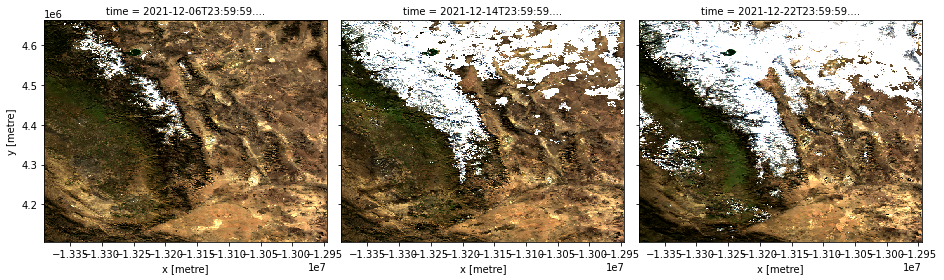

In [7]:
vis.plot.imshow(col="time", rgb="band", col_wrap=3, robust=True, size=4);

In [ ]:
# Enable the hvplot accessor
import hvplot.xarray  # noqa: F401

hvplot_kwargs = {
    "frame_width": 250,
    "xaxis": None,
    "yaxis": None,
    "widget_location": "bottom",
    "aspect": len(data.x) / len(data.y),
}

vis.hvplot.rgb("x", "y", bands="band", groupby="time", **hvplot_kwargs)

If you're working in running notebook, that will display a [HoloViews](https://holoviews.org/) plot with an interactive slider to control the date visualized.

<img src="modis-imagery-hvplot.png" align="left" width="50%" alt="modis imagery with a datetime slider."/>

### User guides

- MOD09: https://lpdaac.usgs.gov/documents/925/MOD09_User_Guide_V61.pdf